# Import Libraries

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Read train csv

In [69]:
train_tweets = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')

In [70]:
train_tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [71]:
train_tweets.shape

(41157, 6)

In [72]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [73]:
train_tweets['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [74]:
train_tweets.duplicated().sum()

0

In [75]:
train_tweets.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

I only need the columns OriginalTweet and Sentiment.

In [76]:
train_tweets = train_tweets[['OriginalTweet', 'Sentiment']]

In [77]:
train_tweets.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Read test csv

In [78]:
test_tweets = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [79]:
test_tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [80]:
test_tweets = test_tweets[['OriginalTweet', 'Sentiment']]

In [81]:
test_tweets.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [82]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3798 non-null   object
 1   Sentiment      3798 non-null   object
dtypes: object(2)
memory usage: 59.5+ KB


We often meet special characters, links and alphanumeric words.  

Special characteres like '@' or '#' are common in such datasets because of users' tags and hash-tags. 

These have to be excluded.

# Preprocess

## Remove URLs, mentions, hashtags, emojis --> using Regex

### train set

In [83]:
# Remove links
train_tweets['cleaned'] = train_tweets['OriginalTweet'].str.replace(
    r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', regex=True
)
#https?: Matches http or https (the ? makes the s optional)
#:\/\/: Escapes the :// in URLs 
#([\da-z\.-]+): Matches the domain (e.g., "google", "nytimes")
#\d = digits, a-z = lowercase letters, . and - = dot and dash
#\.([a-z\.]{2,6}): Matches the top-level domain like .com, .org, etc.
#([\/\w \.-]*): Matches the rest of the URL path (/abc/xyz, etc.)
#/\w \.- = slashes, letters/numbers, dots, spaces, hyphens


# Remove words starting with @ (mentions)
train_tweets['cleaned'] = train_tweets['cleaned'].str.replace(
    r'@\w+', '', regex=True
)
#@: Matches the @ symbol
#\w+: Matches one or more "word characters" (letters, digits, or underscores)


# Remove words starting with # (hashtags)
train_tweets['cleaned'] = train_tweets['cleaned'].str.replace(
    r'#\w+', '', regex=True
)
##: Matches the hash symbol
#\w+: Again, matches word characters following it

# Substituting multiple spaces with single space
train_tweets['cleaned'] = train_tweets['cleaned'].str.replace(
    r'\s+', ' ', regex=True
)
#\s: Matches any whitespace character (spaces, tabs, newlines)
#+: Means "one or more"


# Keep only alphabetical words (remove punctuation, alphanumerics, etc.)
train_tweets['cleaned'] = train_tweets['cleaned'].str.replace(
    r'[^\w\s]', '', regex=True
)
#[]: Denotes a character set
#^: When inside a set, it means "not"
#\w: Word characters (letters, digits, underscore)
#\s: Whitespace characters



In [84]:
train_tweets.head(10)

,OriginalTweet,Sentiment,cleaned
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is PLE...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the outbr...
5,As news of the regionÂs first confirmed COVID...,Positive,As news of the regionÂs first confirmed COVID1...
6,Cashier at grocery store was sharing his insig...,Positive,Cashier at grocery store was sharing his insig...
7,Was at the supermarket today. Didn't buy toile...,Neutral,Was at the supermarket today Didnt buy toilet ...
8,Due to COVID-19 our retail store and classroom...,Positive,Due to COVID19 our retail store and classroom ...
9,"For corona prevention,we should stop to buy th...",Negative,For corona preventionwe should stop to buy thi...


### test set

In [85]:
# Remove links
test_tweets['cleaned'] = test_tweets['OriginalTweet'].str.replace(
    r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', regex=True
)
#https?: Matches http or https (the ? makes the s optional)
#:\/\/: Escapes the :// in URLs 
#([\da-z\.-]+): Matches the domain (e.g., "google", "nytimes")
#\d = digits, a-z = lowercase letters, . and - = dot and dash
#\.([a-z\.]{2,6}): Matches the top-level domain like .com, .org, etc.
#([\/\w \.-]*): Matches the rest of the URL path (/abc/xyz, etc.)
#/\w \.- = slashes, letters/numbers, dots, spaces, hyphens


# Remove words starting with @ (mentions)
test_tweets['cleaned'] = test_tweets['cleaned'].str.replace(
    r'@\w+', '', regex=True
)
#@: Matches the @ symbol
#\w+: Matches one or more "word characters" (letters, digits, or underscores)


# Remove words starting with # (hashtags)
test_tweets['cleaned'] = test_tweets['cleaned'].str.replace(
    r'#\w+', '', regex=True
)
##: Matches the hash symbol
#\w+: Again, matches word characters following it

# Substituting multiple spaces with single space
test_tweets['cleaned'] = test_tweets['cleaned'].str.replace(
    r'\s+', ' ', regex=True
)
#\s: Matches any whitespace character (spaces, tabs, newlines)
#+: Means "one or more"


# Keep only alphabetical words (remove punctuation, alphanumerics, etc.)
test_tweets['cleaned'] = test_tweets['cleaned'].str.replace(
    r'[^\w\s]', '', regex=True
)
#[]: Denotes a character set
#^: When inside a set, it means "not"
#\w: Word characters (letters, digits, underscore)
#\s: Whitespace characters


In [86]:
test_tweets.head(10)

,OriginalTweet,Sentiment,cleaned
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING New Yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldnt find hand sanitizer at Fred Mey...
2,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits City as anxious shoppers stock up...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,One week everyone buying baby milk powder the...
5,Do you remember the last time you paid $2.99 a...,Neutral,Do you remember the last time you paid 299 a g...
6,Voting in the age of #coronavirus = hand sanit...,Positive,Voting in the age of hand sanitizer
7,"@DrTedros ""We canÂt stop #COVID19 without pro...",Neutral,We canÂt stop without protecting Prices of s...
8,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative,HI TWITTER I am a pharmacist I sell hand sanit...
9,Anyone been in a supermarket over the last few...,Extremely Positive,Anyone been in a supermarket over the last few...


Stop words are words which are filtered out before or after processing of natural language data (such as “the”, “a”, “an”, “in”) . 

In [87]:
stop_words = stopwords.words("english")

In [88]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# Text Normalization

Here we have two methods, lemmatization and stemming. Their goal is to reduce words to a base/root form so that variations of a word are treated the same during analysis. 

In my case I will choose lemmatization because:

- Preserves word meaning (e.g. "better" → "good", "running" → "run")

- Respects part of speech, which matters for sentiment

- Keeps the sentence semantically intact

Stemmers are more aggresive and thus lemmatizers are prefered.

NLTL provides us different lemmatizers and stemmers to handle such task. We will use WordNetLemmatizer.

## Lemmatization

In [89]:
lemmatizer = WordNetLemmatizer()

In [90]:
# for each cell, we split the words in  a list of words, and if this word is not in stopwords we lemmatize it. 
# Then the list of words is again concatenated as a sentence and lower case is applied.
train_tweets['cleaned'] = train_tweets['cleaned'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) \
                                                            for i in re.sub("[^a-zA-Z]", " ",\
                                                                          str(x)).split() if i not in stop_words]).lower())

In [91]:
train_tweets.shape

(41157, 3)

In [92]:
#example of a cleaned tweet
train_tweets['cleaned'][6]

'cashier grocery store sharing insight to prove credibility commented im civics class i know im talking'

In [93]:

test_tweets['cleaned'] = test_tweets['cleaned'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) \
                                                            for i in re.sub("[^a-zA-Z]", " ",\
                                                                          str(x)).split() if i not in stop_words]).lower())


### POS tagging

Lemmatizers need to know the role of a word in a sentence to convert it to the correct base form.

By default, most lemmatizers (like NLTK’s WordNetLemmatizer) assume the word is a noun unless told otherwise.

POS tagging tells the lemmatizer the correct "type" of word, so it can choose the right lemma.

In [94]:
#we turn words in tokens and apply Part of Speech Tagging
train_tweets['cleaned'] = train_tweets['cleaned'].apply(word_tokenize).apply(pos_tag)
train_tweets['cleaned'][6]

[('cashier', 'NN'),
 ('grocery', 'NN'),
 ('store', 'NN'),
 ('sharing', 'VBG'),
 ('insight', 'NN'),
 ('to', 'TO'),
 ('prove', 'VB'),
 ('credibility', 'NN'),
 ('commented', 'VBN'),
 ('im', 'JJ'),
 ('civics', 'NNS'),
 ('class', 'NN'),
 ('i', 'NN'),
 ('know', 'VBP'),
 ('im', 'NN'),
 ('talking', 'VBG')]

In [95]:
test_tweets['cleaned'] = test_tweets['cleaned'].apply(word_tokenize).apply(pos_tag)

According to theory not all part of speech are importan to sentiment analysis. 

There is no universal guidance what we should keep and what not but as a rule of thump from linguistics nouns , adjectives and adverbs include the most meaningfull information on sentiment analysis.

We will create a function to filter only tokens of our interest regarding their POS classification.

In [96]:
tag_filter = ["NN","NNS","NNP","NNPS","RB","RBR","RBS","JJ","JJR","JJS"]  #keep only nouns ,adjectives and adverbs 

def pos_filter(row):  
    keep_list=[]
    for x,y in row:
        if y in tag_filter:
           keep_list.append(x) 

    return keep_list

In [97]:
train_tweets['cleaned'] =train_tweets['cleaned'].apply(pos_filter)
test_tweets['cleaned'] =test_tweets['cleaned'].apply(pos_filter)

In [98]:
train_tweets.head(10)

,OriginalTweet,Sentiment,cleaned
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[]
1,advice Talk to your neighbours family to excha...,Positive,"[advice, family, exchange, phone, number, crea..."
2,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, elderly, hour, covid,..."
3,My food stock is not the only one which is emp...,Positive,"[food, stock, please, panic, enough, food, eve..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[ready, supermarket, outbreak, not, im, parano..."
5,As news of the regionÂs first confirmed COVID...,Positive,"[news, region, first, covid, case, sullivan, c..."
6,Cashier at grocery store was sharing his insig...,Positive,"[cashier, grocery, store, insight, credibility..."
7,Was at the supermarket today. Didn't buy toile...,Neutral,"[supermarket, today, toilet, paper]"
8,Due to COVID-19 our retail store and classroom...,Positive,"[due, covid, retail, store, classroom, open, w..."
9,"For corona prevention,we should stop to buy th...",Negative,"[corona, preventionwe, buy, thing, cash, use, ..."


In [99]:
# Make list of tokens again one string in order to be processed

train_tweets['cleaned'] = train_tweets['cleaned'].apply(lambda x: ' '.join(x))
test_tweets['cleaned'] = test_tweets['cleaned'].apply(lambda x: ' '.join(x))


In [100]:
train_tweets.head(10)

,OriginalTweet,Sentiment,cleaned
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice family exchange phone number create con...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia elderly hour covid outbreak
3,My food stock is not the only one which is emp...,Positive,food stock please panic enough food everyone t...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket outbreak not im paranoid foo...
5,As news of the regionÂs first confirmed COVID...,Positive,news region first covid case sullivan county l...
6,Cashier at grocery store was sharing his insig...,Positive,cashier grocery store insight credibility im c...
7,Was at the supermarket today. Didn't buy toile...,Neutral,supermarket today toilet paper
8,Due to COVID-19 our retail store and classroom...,Positive,due covid retail store classroom open walkin b...
9,"For corona prevention,we should stop to buy th...",Negative,corona preventionwe buy thing cash use online ...


# Classification

<Axes: xlabel='Sentiment'>

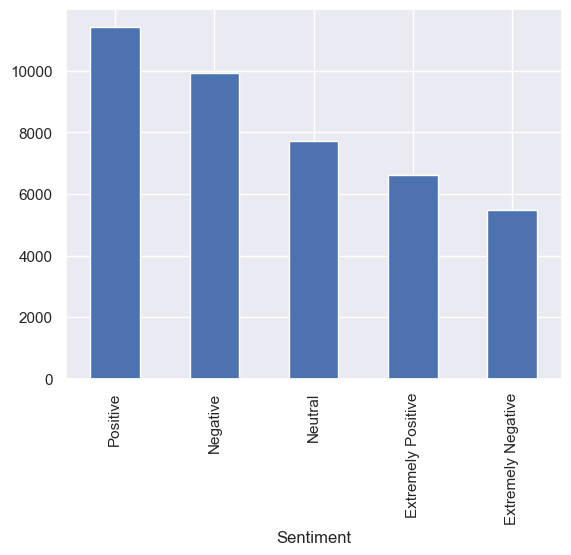

In [101]:
train_tweets['Sentiment'].value_counts().plot.bar(ylim=0)

In [102]:
#Transform Categories to numeric so our classifier can handle it
train_tweets['Sentiment'] = train_tweets['Sentiment'].replace({'Positive':1, 'Negative':0, 'Neutral':2, 'Extremely Positive':3, 'Extremely Negative':4})

C:\Users\nikig\AppData\Local\Temp\ipykernel_29568\851784608.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_tweets['Sentiment'] = train_tweets['Sentiment'].replace({'Positive':1, 'Negative':0, 'Neutral':2, 'Extremely Positive':3, 'Extremely Negative':4})


In [103]:
#Transform Categories to numeric so our classifier can handle it
test_tweets['Sentiment'] = test_tweets['Sentiment'].replace({'Positive':1, 'Negative':0, 'Neutral':2, 'Extremely Positive':3, 'Extremely Negative':4})

C:\Users\nikig\AppData\Local\Temp\ipykernel_29568\665607192.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_tweets['Sentiment'] = test_tweets['Sentiment'].replace({'Positive':1, 'Negative':0, 'Neutral':2, 'Extremely Positive':3, 'Extremely Negative':4})


## X_train, X_test, y_train, y_test

In [104]:
X_train = train_tweets['cleaned']
y_train = train_tweets['Sentiment']

X_test = test_tweets['cleaned']
y_test = test_tweets['Sentiment']

## TF-IDF Vectorizer

Algorithms do not understand words so we need to transform our text into a numeric representation. 

TfidfVectorizer does this transformation for us.

In [105]:
vectorizer = TfidfVectorizer(lowercase=False) #is already lowercase
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Algorithms

### Random Forest

In [106]:
clf=RandomForestClassifier()
clf.fit(X_train, y_train)
print('RandomForestClassifier :')

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

RandomForestClassifier :
              precision    recall  f1-score   support

           0       0.44      0.41      0.42      1041
           1       0.39      0.54      0.45       947
           2       0.48      0.65      0.55       619
           3       0.62      0.32      0.42       599
           4       0.54      0.33      0.41       592

    accuracy                           0.45      3798
   macro avg       0.49      0.45      0.45      3798
weighted avg       0.48      0.45      0.45      3798



### Logistic Regression

In [107]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.33      0.39      1041
           1       0.44      0.37      0.40       947
           2       0.47      0.68      0.55       619
           3       0.55      0.61      0.58       599
           4       0.48      0.58      0.53       592

    accuracy                           0.48      3798
   macro avg       0.48      0.51      0.49      3798
weighted avg       0.48      0.48      0.47      3798



### Multinomial Naive Bayes


In [108]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.42      0.41      1041
           1       0.32      0.85      0.46       947
           2       0.65      0.09      0.16       619
           3       0.71      0.05      0.10       599
           4       0.70      0.02      0.05       592

    accuracy                           0.35      3798
   macro avg       0.56      0.29      0.24      3798
weighted avg       0.52      0.35      0.28      3798



Poor results

### Support Vector Machines

In [109]:

svm = LinearSVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

c:\Users\nikig\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.45      0.34      0.39      1041
           1       0.41      0.35      0.38       947
           2       0.47      0.63      0.54       619
           3       0.52      0.62      0.57       599
           4       0.50      0.57      0.53       592

    accuracy                           0.47      3798
   macro avg       0.47      0.50      0.48      3798
weighted avg       0.46      0.47      0.46      3798



For a 5-class sentiment classification problem on tweets, the current results (around 48% accuracy, f1-scores in the 0.4–0.5 range) are not unusual since we are using classical ML algorithms.

- The dataset has overlapping classes (like Positive vs. Extremely Positive).

- We are using TF-IDF, which ignores context and word order.